In [1]:
import spatioloji_s as sj
import numpy as pd
import pandas as pd
import psutil
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
os.getcwd()


'/carc/scratch/projects/amitra2016502/spatioloji_s/example'

In [3]:
mem = psutil.virtual_memory()
print(f"Total memory available: {mem.total / 1024**3:.2f} GB")
cpus = os.cpu_count()
print(f"Total cpu cores available: {cpus}")
print(f"current work directory is {os.getcwd()}")

Total memory available: 251.40 GB
Total cpu cores available: 64
current work directory is /carc/scratch/projects/amitra2016502/spatioloji_s/example


In [4]:
# Load your spatioloji object
sp = sj.data.spatioloji.from_pickle('my_data_objects/run_workflow_impute_spatioloji.pickle')


Loading spatioloji from: my_data_objects/run_workflow_impute_spatioloji.pickle
✓ Loaded: 25,368 cells × 960 genes


In [5]:
print(f"Cells : {sp.n_cells:,}")
print(f"Genes : {sp.n_genes:,}")
print(f"FOVs  : {sp.n_fovs}")
print(f"FOV IDs (first 5): {list(sp.fov_index[:5])}")
print(f"\nCell meta columns: {list(sp.cell_meta.columns[:8])}")

Cells : 25,368
Genes : 960
FOVs  : 20
FOV IDs (first 5): ['001', '002', '004', '005', '006']

Cell meta columns: ['fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px']


# ============================================================
# Section 1: FOV-wise Spatial Graph Building
# ============================================================

## --- Point-based (centroid KNN) graphs ---

In [6]:
point_graphs = {}

for fov_id in sp.fov_index:
    sp_fov = sp.subset_by_fovs([fov_id])
    
    if sp_fov.n_cells < 10:  # skip very sparse FOVs
        print(f"  Skipping FOV {fov_id}: too few cells ({sp_fov.n_cells})")
        continue
    
    graph = sj.spatial.point.build_knn_graph(sp_fov, k=10)
    point_graphs[fov_id] = (sp_fov, graph)

print(f"\n✓ Built point graphs for {len(point_graphs)} FOVs")


Subsetting by FOVs: 1 FOVs requested

Subsetting by cells: 724 cells requested

Initializing spatioloji
[1/11] Master indices: 724 cells × 960 genes
[2/11] Expression matrix: sparse (0.7 MB)
[3/10] Cell metadata: 83 columns
[4/11] Gene metadata: 11 columns
[5/11] Spatial coordinates: 724 cells
[6/11] Polygons: 20136 vertices for 724 cells
[7/11] Images: 1 total, 0 loaded
[8/11] FOV system: 1 FOVs
[9/11] Index maps created
[10/11] Validation: ✓ All consistent
[11/11] Layers and Embeddings initialized (empty)

Spatioloji Object Summary:
  Cells:              724
  Genes:              960
  FOVs:               1
  Images:             1 (0 loaded)
  Original Expression:         sparse
  Has polygons:       True
  Memory (approx):    4.3 MB

✓ Created subset: 724 cells, 1 FOVs
  ✓ KNN graph: k=10, 4301 edges, mean degree=11.9

Subsetting by FOVs: 1 FOVs requested

Subsetting by cells: 427 cells requested

Initializing spatioloji
[1/11] Master indices: 427 cells × 960 genes
[2/11] Expressio

## --- Polygon-based (contact) graphs ---

In [7]:
poly_graphs = {}

for fov_id in sp.fov_index:
    if sp.polygons is None:
        print("No polygon data available — skipping polygon graphs")
        break
    
    sp_fov = sp.subset_by_fovs([fov_id])
    
    if sp_fov.n_cells < 10:
        continue
    
    graph = sj.spatial.polygon.build_contact_graph(sp_fov)
    poly_graphs[fov_id] = (sp_fov, graph)

print(f"\n✓ Built polygon contact graphs for {len(poly_graphs)} FOVs")


Subsetting by FOVs: 1 FOVs requested

Subsetting by cells: 724 cells requested

Initializing spatioloji
[1/11] Master indices: 724 cells × 960 genes
[2/11] Expression matrix: sparse (0.7 MB)
[3/10] Cell metadata: 83 columns
[4/11] Gene metadata: 11 columns
[5/11] Spatial coordinates: 724 cells
[6/11] Polygons: 20136 vertices for 724 cells
[7/11] Images: 1 total, 0 loaded
[8/11] FOV system: 1 FOVs
[9/11] Index maps created
[10/11] Validation: ✓ All consistent
[11/11] Layers and Embeddings initialized (empty)

Spatioloji Object Summary:
  Cells:              724
  Genes:              960
  FOVs:               1
  Images:             1 (0 loaded)
  Original Expression:         sparse
  Has polygons:       True
  Memory (approx):    4.3 MB

✓ Created subset: 724 cells, 1 FOVs

[Polygon Graph] Building contact graph (predicate='intersects')...
Converting to GeoDataFrame (global coordinates)...
  ✓ Created GeoDataFrame: 724 cells
  ✓ Contact graph: 724 cells, 549 edges
    Mean degree: 1.5


### If sjoin finds zero intersections (error message will show up), meaning the polygons are valid but don't actually touch each other. This is common in CosMx data — there are small pixel gaps between cell boundaries.
### The fix: use build_buffer_graph with a small buffer instead of build_contact_graph:

In [13]:
# Check actual polygon-to-polygon distances (not centroid-to-centroid)
from shapely.ops import nearest_points

geoms = gdf.geometry.values

# For first 20 cells, measure true polygon edge distance to nearest neighbor
nn = NearestNeighbors(n_neighbors=2).fit(centroids)
_, indices = nn.kneighbors(centroids[:20])

poly_dists = []
for i, neighbors in enumerate(indices):
    nearest_j = neighbors[1]  # skip self
    dist = geoms[i].distance(geoms[nearest_j])
    poly_dists.append(dist)

poly_dists = np.array(poly_dists)
print(f"Polygon edge-to-edge distances (nearest neighbor):")
print(f"  min   : {poly_dists.min():.2f} px")
print(f"  mean  : {poly_dists.mean():.2f} px")
print(f"  max   : {poly_dists.max():.2f} px")
print(f"  median: {np.median(poly_dists):.2f} px")

# Also check typical cell size
areas = gdf.geometry.area
diameters = np.sqrt(areas / np.pi) * 2  # approximate diameter
print(f"\nApprox cell diameter:")
print(f"  mean  : {diameters.mean():.2f} px")
print(f"  median: {np.median(diameters):.2f} px")

Polygon edge-to-edge distances (nearest neighbor):
  min   : 0.00 px
  mean  : 15.21 px
  max   : 190.38 px
  median: 0.00 px

Approx cell diameter:
  mean  : 86.11 px
  median: 85.47 px


In [18]:
# --- Quick graph stats summary ---
summary = []
for fov_id, (sp_fov, g) in poly_graphs.items():
    summary.append({
        'fov': fov_id,
        'n_cells': sp_fov.n_cells,
        'n_edges': g.n_edges,
        'mean_degree': round(g.mean_degree, 2),
    })

pd.DataFrame(summary).set_index('fov')

,n_cells,n_edges,mean_degree
fov,,,
001,724,549,1.52
002,427,289,1.35
004,1963,2237,2.28
005,1812,1900,2.10
006,1366,1292,1.89
007,1714,1666,1.94
008,723,455,1.26
009,1476,1444,1.96
010,1114,903,1.62


# ============================================================
# Section 3: Neighborhood Analysis (per FOV)
# ============================================================

In [9]:

# --- 3a. Neighborhood Composition ---
# What cell types surround each cell?
comp_results = {}

for fov_id, (sp_fov, graph) in poly_graphs.items():
    comp = sj.spatial.polygon.neighborhood_composition(
        sp_fov, graph, group_col='leiden'
    )
    comp_results[fov_id] = comp

print(f"✓ Composition done for {len(comp_results)} FOVs")
print(f"  Example shape: {comp_results[sp.fov_index[0]].shape}")  # (n_cells, n_types)


[Neighborhoods] Computing composition by 'leiden'...
  ✓ Stored 7 columns with prefix 'nhood_leiden_'
  ✓ Composition: 724 cells, 7 types, mode='fraction'

[Neighborhoods] Computing composition by 'leiden'...
  ✓ Stored 7 columns with prefix 'nhood_leiden_'
  ✓ Composition: 427 cells, 7 types, mode='fraction'

[Neighborhoods] Computing composition by 'leiden'...
  ✓ Stored 7 columns with prefix 'nhood_leiden_'
  ✓ Composition: 1963 cells, 7 types, mode='fraction'

[Neighborhoods] Computing composition by 'leiden'...
  ✓ Stored 7 columns with prefix 'nhood_leiden_'
  ✓ Composition: 1812 cells, 7 types, mode='fraction'

[Neighborhoods] Computing composition by 'leiden'...
  ✓ Stored 7 columns with prefix 'nhood_leiden_'
  ✓ Composition: 1366 cells, 7 types, mode='fraction'

[Neighborhoods] Computing composition by 'leiden'...
  ✓ Stored 7 columns with prefix 'nhood_leiden_'
  ✓ Composition: 1714 cells, 7 types, mode='fraction'

[Neighborhoods] Computing composition by 'leiden'...
  ✓ St


[Neighborhoods] Enrichment analysis (n_perm=500)...
  → Counting observed contacts...
  → Running 500 permutations...
  ✓ Enrichment analysis complete

  Significant pairs (p < 0.05):
    0 – 0: z=+3.85, p=0.006 (enriched)
    0 – 1: z=-3.94, p=0.004 (depleted)
    0 – 6: z=-2.92, p=0.006 (depleted)
    1 – 1: z=+2.60, p=0.020 (enriched)
    1 – 3: z=-7.73, p=0.002 (depleted)
    2 – 2: z=+3.53, p=0.018 (enriched)
    3 – 3: z=+16.91, p=0.002 (enriched)
    3 – 4: z=-2.85, p=0.010 (depleted)
    3 – 5: z=-4.55, p=0.002 (depleted)
    3 – 6: z=-4.38, p=0.002 (depleted)
    4 – 4: z=+5.00, p=0.004 (enriched)

[Neighborhoods] Enrichment analysis (n_perm=500)...
  → Counting observed contacts...
  → Running 500 permutations...
  ✓ Enrichment analysis complete

  Significant pairs (p < 0.05):
    0 – 0: z=+6.58, p=0.002 (enriched)
    0 – 1: z=-2.31, p=0.026 (depleted)
    0 – 3: z=+4.37, p=0.002 (enriched)
    0 – 4: z=-2.13, p=0.044 (depleted)
    0 – 6: z=-4.39, p=0.002 (depleted)
    4

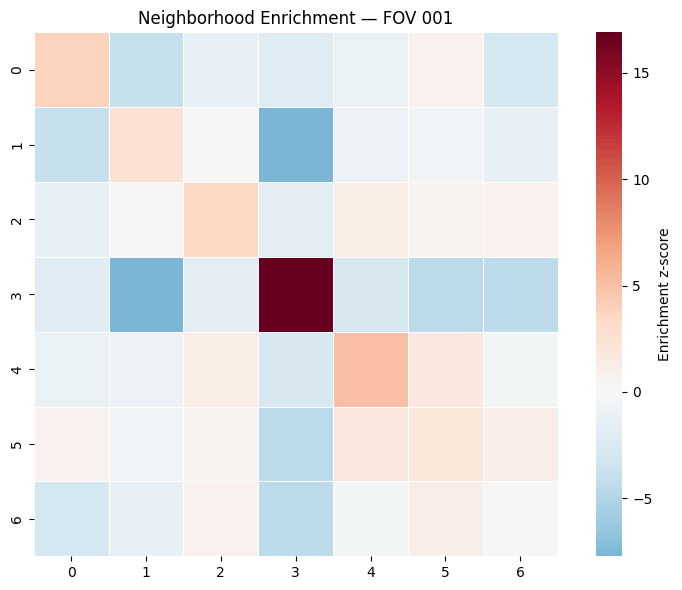

In [10]:
# --- 3b. Neighborhood Enrichment ---
# Which cell type pairs contact each other more/less than expected by chance?
enrichment_results = {}

for fov_id, (sp_fov, graph) in poly_graphs.items():
    enrich = sj.spatial.polygon.neighborhood_enrichment(
        sp_fov, graph, group_col='leiden', n_permutations=500
    )
    enrichment_results[fov_id] = enrich

# Visualize enrichment z-scores for first FOV
import matplotlib.pyplot as plt
import seaborn as sns

fov_id = sp.fov_index[0]
zscore_df = enrichment_results[fov_id]['z_scores']

plt.figure(figsize=(8, 6))
sns.heatmap(zscore_df, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5,
            cbar_kws={'label': 'Enrichment z-score'})
plt.title(f'Neighborhood Enrichment — FOV {fov_id}')
plt.tight_layout()
plt.show()

In [15]:
# --- 3c. Niche Identification ---
# Cluster cells with similar neighborhood compositions into spatial niches
niche_results = {}

for fov_id, (sp_fov, graph) in poly_graphs.items():
    result = sj.spatial.polygon.niche_identification(
        sp_fov, graph, group_col='leiden',
        method='kmeans', n_niches=5
    )
    niche_results[fov_id] = result



[Neighborhoods] Identifying 5 niches (method='kmeans')...

[Neighborhoods] Computing composition by 'leiden'...
  ✓ Composition: 724 cells, 7 types, mode='fraction'
  → KMeans inertia: 1585.8
  ✓ Stored in cell_meta['niche']
  ✓ Niche identification results:
    niche_0: 279 cells
    niche_1: 157 cells
    unassigned: 156 cells
    niche_3: 87 cells
    niche_2: 28 cells
    niche_4: 17 cells

[Neighborhoods] Identifying 5 niches (method='kmeans')...

[Neighborhoods] Computing composition by 'leiden'...
  ✓ Composition: 427 cells, 7 types, mode='fraction'
  → KMeans inertia: 933.8
  ✓ Stored in cell_meta['niche']
  ✓ Niche identification results:
    niche_0: 140 cells
    unassigned: 104 cells
    niche_1: 86 cells
    niche_2: 41 cells
    niche_3: 32 cells
    niche_4: 24 cells

[Neighborhoods] Identifying 5 niches (method='kmeans')...

[Neighborhoods] Computing composition by 'leiden'...
  ✓ Composition: 1963 cells, 7 types, mode='fraction'
  → KMeans inertia: 5803.1
  ✓ Stored i

# ============================================================
# Section 4: Spatial Patterns (per FOV)
# ============================================================

In [19]:
# --- 4a. Moran's I on cell-level metrics ---
# Test if total_counts, cell area, etc. are spatially clustered
morans_results = {}

for fov_id, (sp_fov, graph) in point_graphs.items():
    results = {}
    for metric in ['total_counts', 'cell_area']:
        if metric not in sp_fov.cell_meta.columns:
            continue
        mi = sj.spatial.point.morans_i(
            sp_fov, graph, metric=metric
        )
        results[metric] = mi
    morans_results[fov_id] = results

# Summary table
rows = []
for fov_id, metrics in morans_results.items():
    for metric, mi in metrics.items():
        rows.append({
            'fov': fov_id,
            'metric': metric,
            'I': round(mi['I'], 4),
            'pvalue': round(mi['pvalue'], 4),
            'significant': mi['pvalue'] < 0.05
        })

moran_df = pd.DataFrame(rows)
print(moran_df.pivot(index='fov', columns='metric', values='I'))

TypeError: morans_i() got an unexpected keyword argument 'metric'

In [20]:
point_graphs


{'001': (spatioloji object
    Cells: 724
    Genes: 960
    FOVs:  1
    Images: 1 (0 loaded),
  PointSpatialGraph (method=knn, 724 cells, 4301 edges, mean degree=11.9)),
 '002': (spatioloji object
    Cells: 427
    Genes: 960
    FOVs:  1
    Images: 1 (0 loaded),
  PointSpatialGraph (method=knn, 427 cells, 2513 edges, mean degree=11.8)),
 '004': (spatioloji object
    Cells: 1,963
    Genes: 960
    FOVs:  1
    Images: 1 (0 loaded),
  PointSpatialGraph (method=knn, 1963 cells, 11218 edges, mean degree=11.4)),
 '005': (spatioloji object
    Cells: 1,812
    Genes: 960
    FOVs:  1
    Images: 1 (0 loaded),
  PointSpatialGraph (method=knn, 1812 cells, 10400 edges, mean degree=11.5)),
 '006': (spatioloji object
    Cells: 1,366
    Genes: 960
    FOVs:  1
    Images: 1 (0 loaded),
  PointSpatialGraph (method=knn, 1366 cells, 7896 edges, mean degree=11.6)),
 '007': (spatioloji object
    Cells: 1,714
    Genes: 960
    FOVs:  1
    Images: 1 (0 loaded),
  PointSpatialGraph (method=knn